电场x和y应该近似互为相反数（解释相位差pi现象？）

质量控制？

2个不同采样率信号经过fft,welch,spectrogram等返回的频率可以在前面一部分处处相等，fft较容易实现。

scipy.signal.welch()，返回的频率数组由输入的数组采样率、采用的nperseg,noverlap,return_onesided决定。应该能够通过这些返回一样的频率数组



1b 算法文档中提到 vfm 有截止频率大约 9hz？(Swarm Level 1b Processor Algorithms. pdf, page20)

所以MAGx_HR_1B产品中的磁场数据降采样到16hz（对应的nyquist频率为8hz）不用先进行低通滤波，直接使用时间对齐的方式进行降采样，或者直接间隔多少个点取一个点。

spacecraft = A

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.signal import spectrogram

from pyaw import utils
from pyaw.swarm import rotate_vector_by_quaternion

%load_ext watermark
%watermark -i -v -p matplotlib,numpy,pandas,scipy

Python implementation: CPython
Python version       : 3.11.4
IPython version      : 8.27.0

matplotlib: 3.8.0
numpy     : 1.25.2
pandas    : 2.2.2
scipy     : 1.13.1



In [2]:
fps = [r'D:\cleo\master\pyaw\data\Swarm\SW_OPER_MAGA_HR_1B_12885_20160311T061733_20160311T075106.pkl',
       r'D:\cleo\master\pyaw\data\Swarm\aux_SW_OPER_MAGA_HR_1B_12885_20160311T061733_20160311T075106.pkl',
       r'D:\cleo\master\pyaw\data\Swarm\IGRF_SW_OPER_MAGA_HR_1B_12885_20160311T061733_20160311T075106.pkl',
       r'D:\cleo\master\pyaw\data\Swarm\SW_EXPT_EFIA_TCT16_12885_20160311T061733_20160311T075106.pkl']

In [3]:
df_b = pd.read_pickle(fps[0])
# df_b_aux = pd.read_pickle(fps[1])
df_b_IGRF = pd.read_pickle(fps[2])
df_e = pd.read_pickle(fps[3])

In [5]:
df_b_clip = df_b[['B_NEC', 'Longitude', 'Latitude', 'Radius', 'q_NEC_CRF']]
# df_b_aux_clip = df_b_aux[['QDLat', 'QDLon', 'MLT']]
df_b_IGRF_clip = df_b_IGRF[['B_NEC_IGRF']]
df_e_clip = df_e[['Longitude', 'Latitude', 'Radius', 'VsatE', 'VsatN', 'Ehy', 'Ehx']]

In [6]:
st = '20160311T064000'
et = '20160311T065000'
df_b_clip = df_b_clip.loc[pd.Timestamp(st):pd.Timestamp(et)]
# df_b_aux_clip = df_b_aux_clip.loc[pd.Timestamp(st):pd.Timestamp(et)]
df_b_IGRF_clip = df_b_IGRF_clip.loc[pd.Timestamp(st):pd.Timestamp(et)]
df_e_clip = df_e_clip.loc[pd.Timestamp(st):pd.Timestamp(et)]

np.all(np.equal(df_b_clip.index.values, df_b_IGRF_clip.index.values))

True

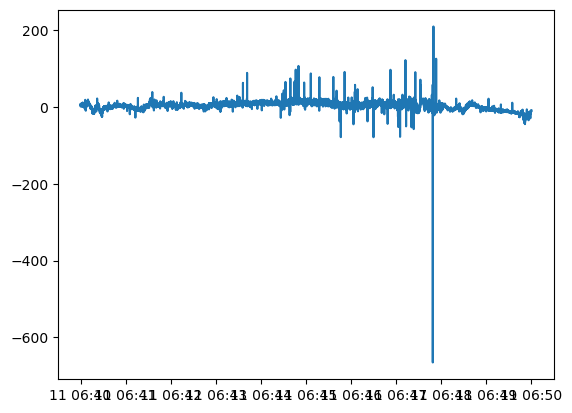

In [7]:
ehx = df_e_clip['Ehx'].values

plt.plot(df_e_clip.index.values, ehx)
plt.show()

972
[  18.740198   18.64161    19.42954    18.584503  -14.915491  -17.801529
  -13.954795  -12.450875  -17.904371  -16.426268  -15.575662  -14.672722
  -15.346132  -14.387139  -13.557536  -14.201348  -12.840782  -17.66667
  -12.905396  -12.594558  -11.631221  -12.170498  -13.635912  -13.108004
  -12.103732   18.829782   22.144665  -13.946195  -12.620305  -13.114768
  -14.099394  -12.921697  -15.782233  -17.147753  -14.791791  -16.649889
  -16.925756  -11.606904  -17.35941   -16.624786  -13.361683  -15.659511
  -13.411228  -13.337054  -18.846119  -20.206148  -21.841982  -19.744074
  -19.563148  -18.614626  -19.940296  -20.747686  -25.058928  -23.01883
  -23.121054  -20.485764  -20.466272  -20.549242  -23.356646  -21.458288
  -25.62835   -25.1073    -24.10843   -19.213387  -19.611397  -12.92522
  -14.12591   -13.152558  -13.35361   -11.681907  -15.933462  -13.23052
  -11.614627  -18.930971  -27.671944   23.78907   -11.681582  -11.643161
  -12.327592  -13.92298   -11.594797   19.695843   

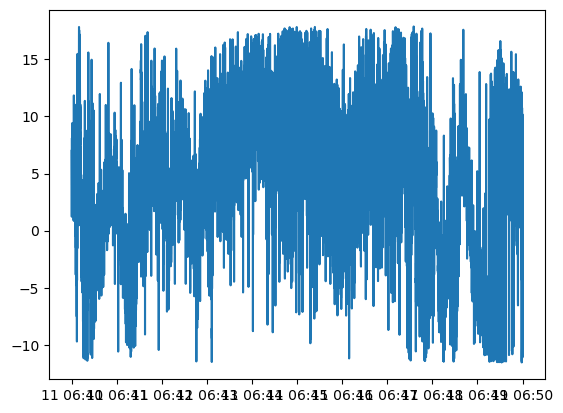

In [8]:
ehx = utils.set_outliers_nan_std(ehx, 1, print_=True)
ehx = utils.get_array_interpolated(df_e_clip.index.values, ehx)

plt.plot(df_e_clip.index.values, ehx)
plt.show()

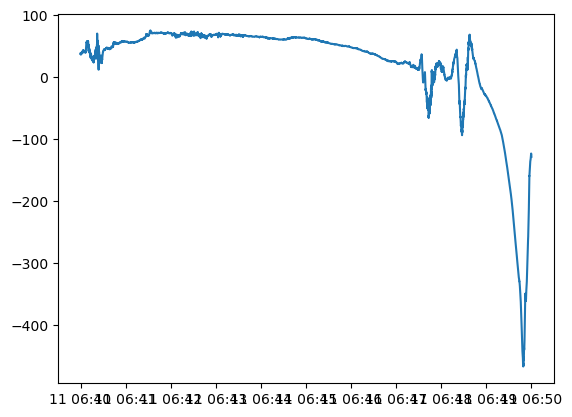

In [9]:
b_sc = []  # b in S/C
b_igrf_sc = []  # igrf b in S/C
for b_nec, b_nec_igrf, q_NEC_CRF in zip(df_b_clip['B_NEC'].values, df_b_IGRF_clip['B_NEC_IGRF'].values,
                                        df_b_clip['q_NEC_CRF'].values):
    q_CRF_NEC = np.array([-q_NEC_CRF[0], -q_NEC_CRF[1], -q_NEC_CRF[2], q_NEC_CRF[3]])
    b_sc.append(rotate_vector_by_quaternion(b_nec, q_CRF_NEC))
    b_igrf_sc.append(rotate_vector_by_quaternion(b_nec_igrf, q_CRF_NEC))
b_sc = np.array(b_sc)
b_igrf_sc = np.array(b_igrf_sc)

by1 = b_sc[:, 1] - b_igrf_sc[:, 1]

plt.plot(df_b_clip.index.values, by1)

In [10]:
datetimes_e = df_e_clip.index.values
datetimes_b = df_b_clip.index.values

by1 = utils.align_high2low(by1, datetimes_b, datetimes_e)

In [11]:
fs = 16
window = 'hann'
stft_window_seconds = 4
nperseg = int(stft_window_seconds * fs)
noverlap = nperseg // 2

freqs, ts, Sxx_e = spectrogram(ehx, fs=fs, window=window, nperseg=nperseg, noverlap=noverlap, mode='complex')
_, _, Sxx_b = spectrogram(by1, fs=fs, window=window, nperseg=nperseg, noverlap=noverlap, mode='complex')

ts_dt64 = datetimes_e[0] + [np.timedelta64(int(_), 's') for _ in ts]

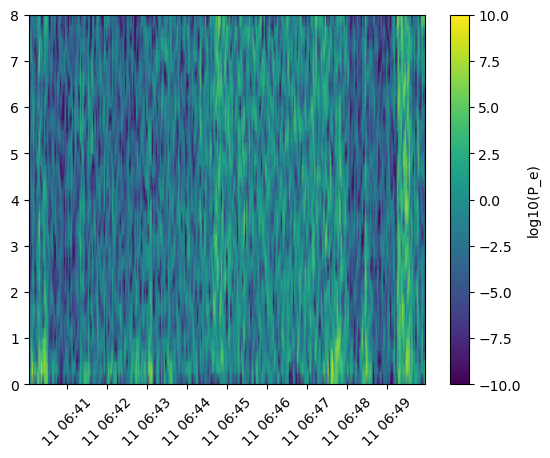

In [12]:
Sxx_e_m = np.abs(Sxx_e)
plt.pcolormesh(ts_dt64, freqs, 10 * np.log10(Sxx_e_m), shading='gouraud', vmin=-10, vmax=10)
plt.colorbar(label='log10(P_e)')
plt.xticks(rotation=45)
plt.show()

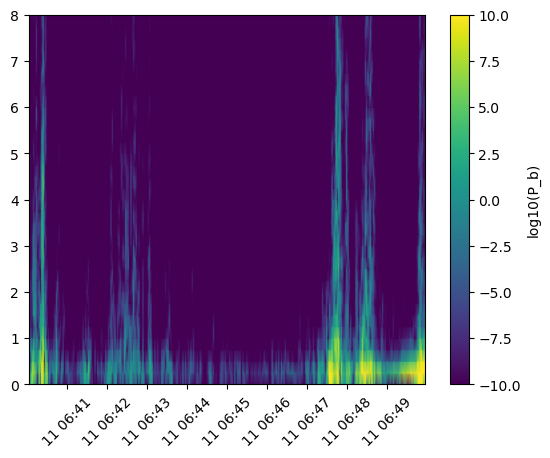

In [13]:
Sxx_b_m = np.abs(Sxx_b)
plt.pcolormesh(ts_dt64, freqs, 10 * np.log10(Sxx_b_m), shading='gouraud', vmin=-10, vmax=10)
plt.colorbar(label='log10(P_b)')
plt.ylim([0, 8])
plt.xticks(rotation=45)
plt.show()

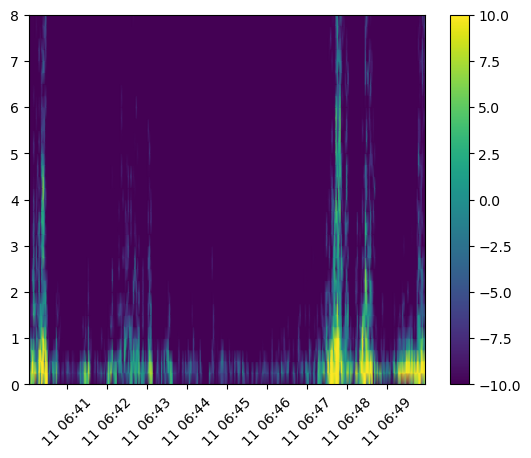

In [14]:
cpsd = Sxx_e * np.conj(Sxx_b)

cpsd_m = np.abs(cpsd)
plt.pcolormesh(ts_dt64, freqs, 10 * np.log10(cpsd_m), shading='gouraud', vmin=-10, vmax=10)
plt.xticks(rotation=45)
plt.colorbar()
plt.show()

In [15]:
step = 11
coherences = utils.get_coherences(Sxx_e, Sxx_b, cpsd)

In [16]:
ts_dt64_split = utils.split_array(ts_dt64)

dts_cohe = [utils.get_middle_element(i) for i in ts_dt64_split]

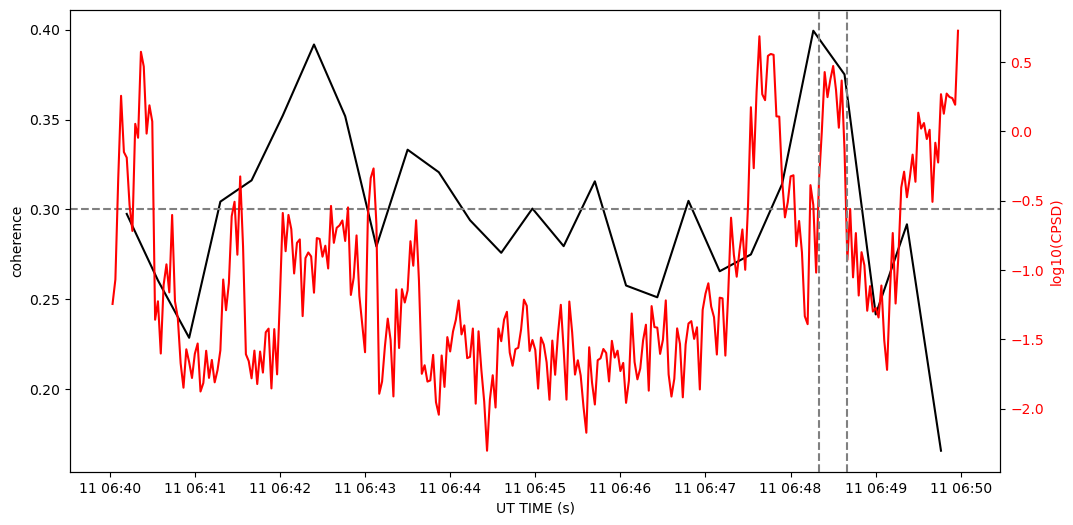

In [17]:
# Create a figure and the first axis
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot the first dataset
ax1.plot(dts_cohe, coherences, color='black', label='coherence')
plt.axhline(0.3, color='gray', linestyle='--')
ax1.set_xlabel('UT TIME (s)')
ax1.set_ylabel('coherence', color='black')
ax1.tick_params(axis='y', labelcolor='black')

# Create a second y-axis with its own x-axis
ax2 = ax1.twinx()  # Share the same x-axis
ax2.plot(ts_dt64, np.log10(cpsd_m.mean(axis=0)), color='red', label='log10(CPSD)')
ax2.set_ylabel('log10(CPSD)', color='red')
ax2.tick_params(axis='y', labelcolor='red')

import matplotlib.dates as mdates

plt.axvline(mdates.date2num(np.datetime64('2016-03-11T06:48:20')), color='gray', linestyle='--')
plt.axvline(mdates.date2num(np.datetime64('2016-03-11T06:48:40')), color='gray', linestyle='--')
plt.xticks(rotation=45)
plt.show()

# dynamic: 06:47:35-06:48:55

In [18]:
st_dy = np.datetime64('2016-03-11T06:47:35')
et_dy = np.datetime64('2016-03-11T06:47:55')
t_mask = (datetimes_e >= st_dy) & (datetimes_e <= et_dy)
datetimes_dy = datetimes_e[t_mask]
ehx_dy = ehx[t_mask]
by1_dy = by1[t_mask]

In [19]:
ehx_dy_fft = utils.FFT(ehx_dy, fs)
by1_dy_fft = utils.FFT(by1_dy, fs)

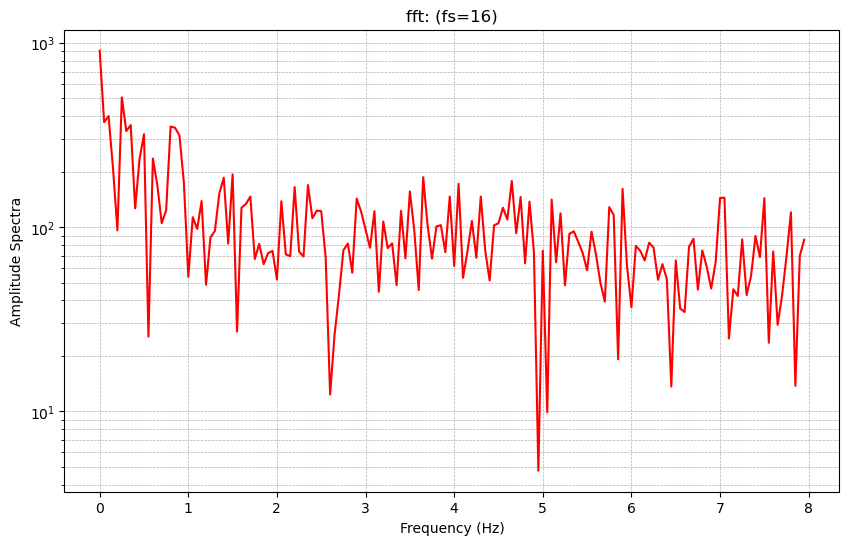

In [20]:
ehx_dy_fft.plot_fft()
plt.show()

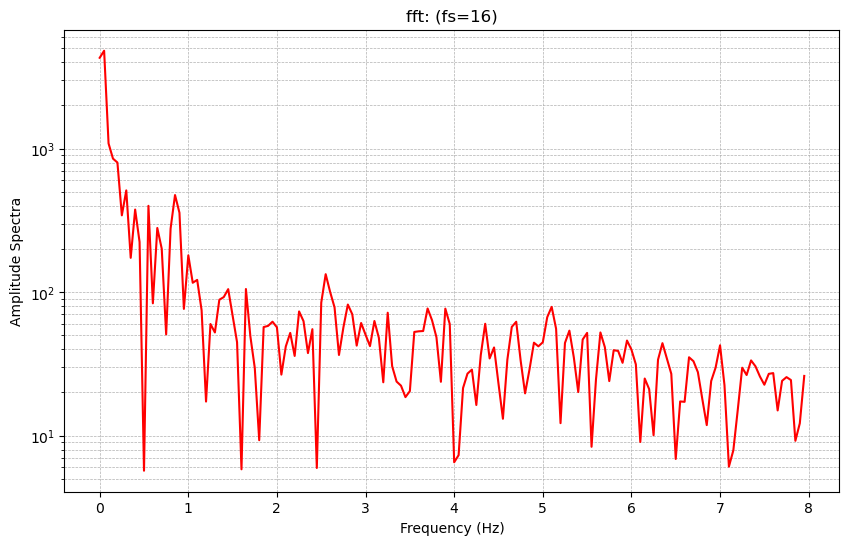

In [21]:
by1_dy_fft.plot_fft()
plt.show()

In [22]:
freqs_dy, amp_e_dy, _ = ehx_dy_fft.get_fft()
_, amp_b_dy, _ = by1_dy_fft.get_fft()

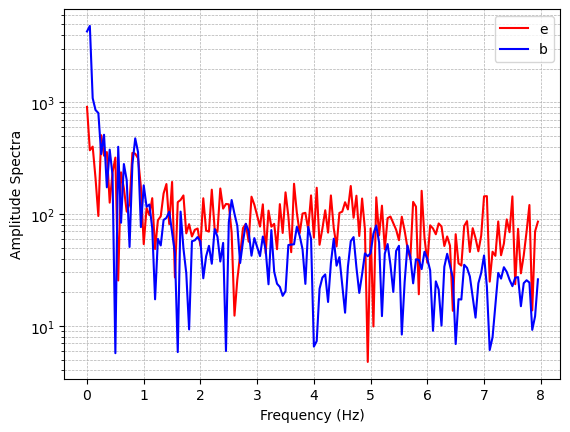

In [23]:
plt.plot(freqs_dy, amp_e_dy, color='red', label='e')
plt.plot(freqs_dy, amp_b_dy, color='blue', label='b')
plt.legend()
plt.xscale('linear')
plt.yscale('log')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude Spectra')
plt.grid(which='both', linestyle='--', linewidth=0.5)
plt.show()

In [24]:
eb_ratio_fft_dy = amp_e_dy / amp_b_dy
eb_ratio_fft_dy = eb_ratio_fft_dy * 1e-3 * 1e9  # 此处考虑了单位换算

In [25]:
from pyaw.paras import mu0

Sigma_P_dy = 3.0
Sigma_P_sta = 0.5

va_dy = 1.4e6
va_sta = 1.3e6

boundary_l_dy = 1 / (mu0 * Sigma_P_dy)
boundary_h_dy = mu0 * va_dy ** 2 * Sigma_P_dy

boundary_l_sta = 1 / (mu0 * Sigma_P_sta)
boundary_h_sta = mu0 * va_sta ** 2 * Sigma_P_sta

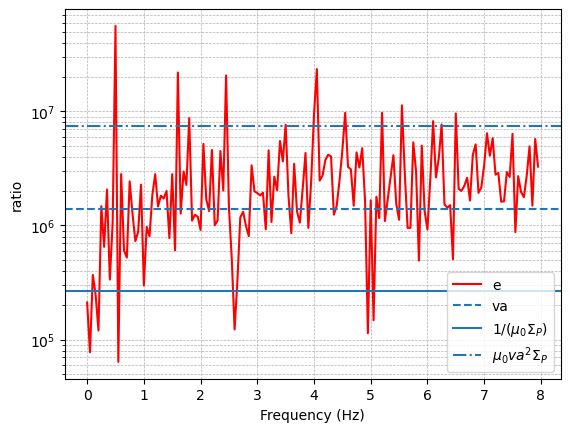

In [26]:
plt.plot(freqs_dy, eb_ratio_fft_dy, color='red', label='e')
plt.axhline(va_dy, linestyle='--', label='va')
plt.axhline(boundary_l_dy, linestyle='-', label=r'$1/(\mu_0 \Sigma_P)$')
plt.axhline(boundary_h_dy, linestyle='-.', label=r'$\mu_0 va^2 \Sigma_P$')
plt.xscale('linear')
plt.yscale('log')
plt.legend()
plt.xlabel('Frequency (Hz)')
plt.ylabel('ratio')
plt.grid(which='both', linestyle='--', linewidth=0.5)
plt.show()  # ratio histogram2d 可以作为补充

In [27]:
freqs_dy, ts_dy, Sxx_e_dy = spectrogram(ehx_dy, fs=fs, window=window, nperseg=nperseg, noverlap=noverlap,
                                        mode='complex')
_, _, Sxx_b_dy = spectrogram(by1_dy, fs=fs, window=window, nperseg=nperseg, noverlap=noverlap, mode='complex')

ts_dt64_dy = datetimes_dy[0] + [np.timedelta64(int(_), 's') for _ in ts_dy]

cpsd_dy = Sxx_e_dy * np.conj(Sxx_b_dy)

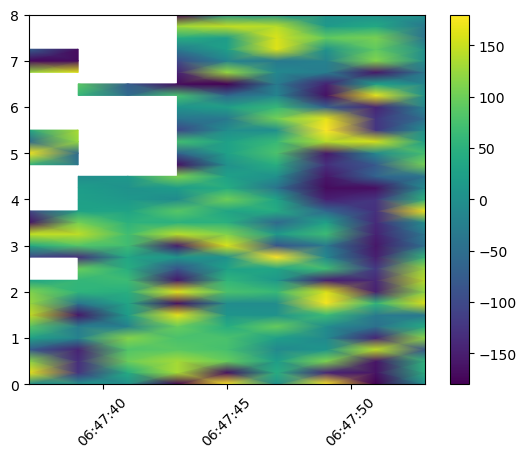

In [28]:
# phase
cpsd_phase_dy = np.degrees(np.angle(cpsd_dy))
cpsd_m_dy = np.abs(cpsd_dy)
cpsd_phase_dy[cpsd_m_dy < 0.03] = np.nan  # 阈值的选择？
plt.pcolormesh(ts_dt64_dy, freqs_dy, cpsd_phase_dy, shading='gouraud')
plt.xticks(rotation=45)
plt.colorbar()
plt.show()

In [29]:
num_bins = 50
phase_bins_dy, phase_histogram2d_dy = utils.get_phase_histogram2d(freqs_dy, cpsd_phase_dy, num_bins=num_bins)

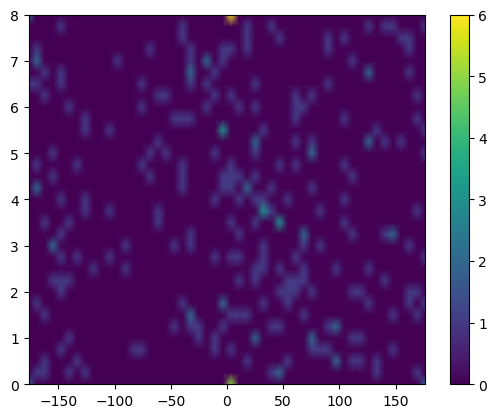

In [30]:
plt.pcolormesh((phase_bins_dy[:-1] + phase_bins_dy[1:]) / 2, freqs_dy, phase_histogram2d_dy, shading='gouraud')
plt.colorbar()
plt.show()

In [31]:
phase_bins_dy_ave = utils.get_phase_histogram_f_ave(phase_bins_dy, phase_histogram2d_dy)

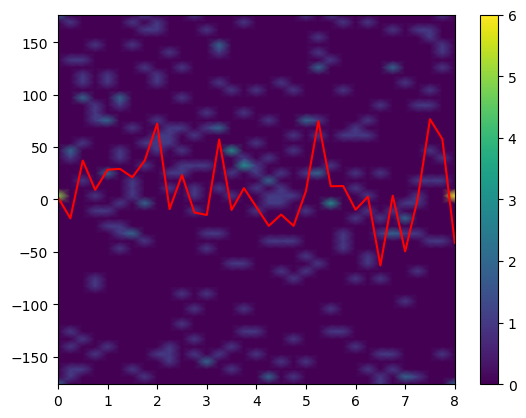

In [32]:
plt.pcolormesh(freqs_dy, (phase_bins_dy[:-1] + phase_bins_dy[1:]) / 2, phase_histogram2d_dy.T, shading='gouraud')
plt.plot(freqs_dy, phase_bins_dy_ave, color='r')
plt.colorbar()
plt.show()  # 因为正负对称导致的在0附近？（求绝对值试一下）

# static: 064705-064725

In [33]:
st_sta = np.datetime64('2016-03-11T06:47:05')
et_sta = np.datetime64('2016-03-11T06:47:25')
t_mask = (datetimes_e >= st_sta) & (datetimes_e <= et_sta)
datetimes_sta = datetimes_e[t_mask]
ehx_sta = ehx[t_mask]
by1_sta = by1[t_mask]

In [34]:
# 当ehx没有处理异常值时，得到的fft和论文区别很大，处理异常之后，2者近似。
ehx_sta_fft = utils.FFT(ehx_sta, fs)
by1_sta_fft = utils.FFT(by1_sta, fs)

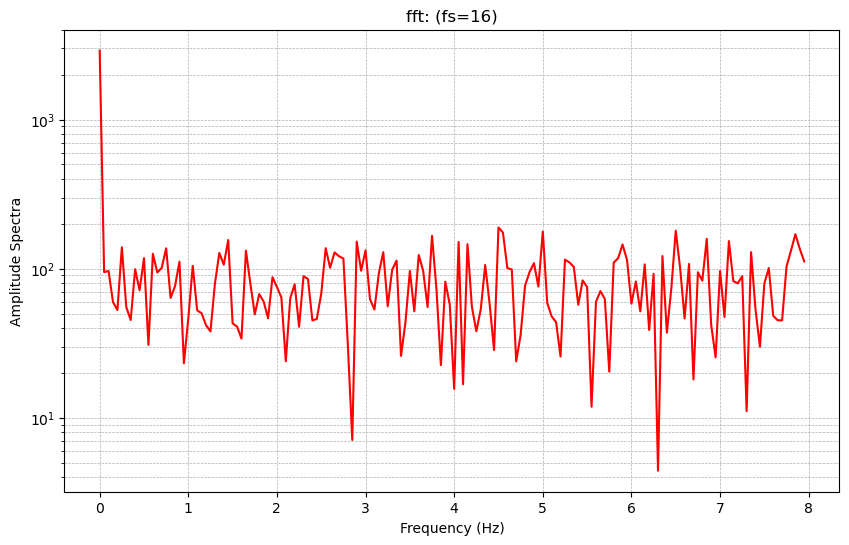

In [35]:
ehx_sta_fft.plot_fft()
plt.show()

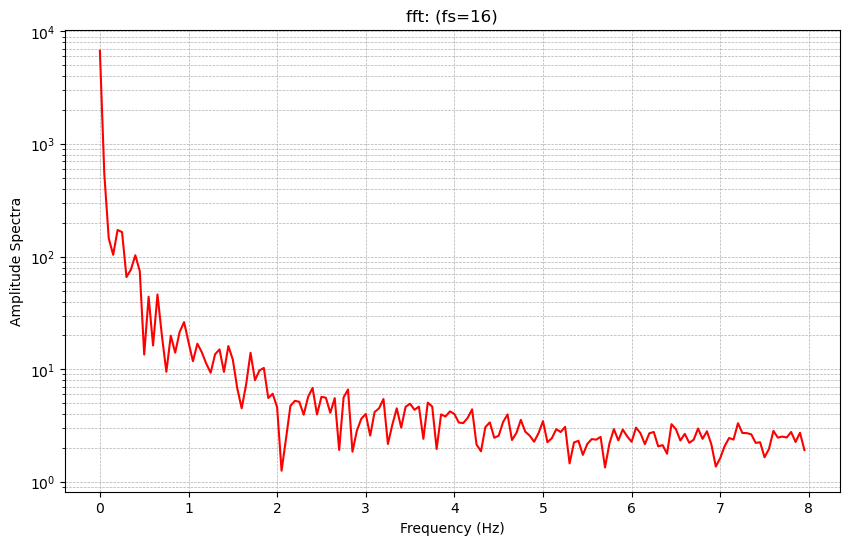

In [36]:
by1_sta_fft.plot_fft()
plt.show()

In [37]:
freqs_sta, amp_e_sta, _ = ehx_sta_fft.get_fft()
_, amp_b_sta, _ = by1_sta_fft.get_fft()

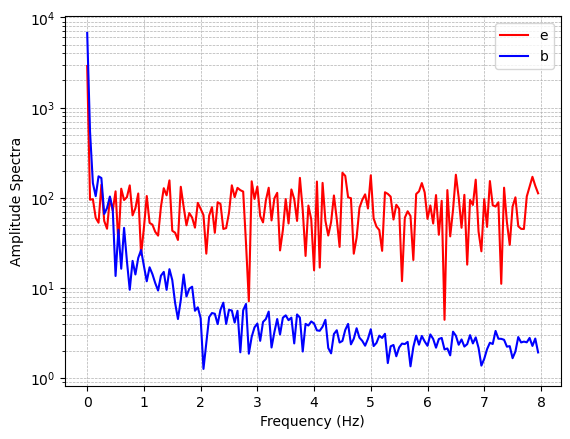

In [38]:
plt.plot(freqs_sta, amp_e_sta, color='red', label='e')
plt.plot(freqs_sta, amp_b_sta, color='blue', label='b')
plt.legend()
plt.xscale('linear')
plt.yscale('log')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude Spectra')
plt.grid(which='both', linestyle='--', linewidth=0.5)
plt.show()

In [39]:
eb_ratio_fft_sta = amp_e_sta / amp_b_sta
eb_ratio_fft_sta = eb_ratio_fft_sta * 1e-3 * 1e9

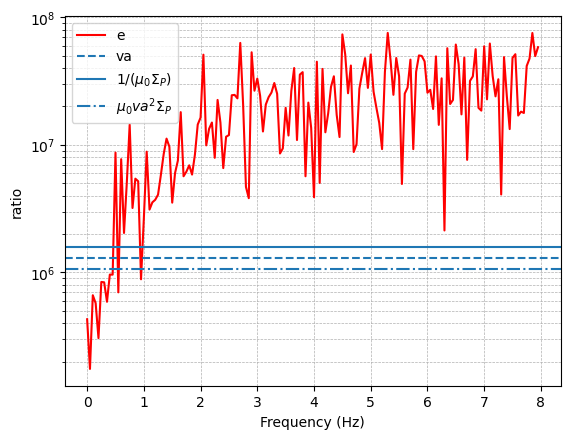

In [40]:
plt.plot(freqs_sta, eb_ratio_fft_sta, color='red', label='e')
plt.axhline(va_sta, linestyle='--', label='va')
plt.axhline(boundary_l_sta, linestyle='-', label=r'$1/(\mu_0 \Sigma_P)$')
plt.axhline(boundary_h_sta, linestyle='-.', label=r'$\mu_0 va^2 \Sigma_P$')
plt.legend()
plt.xscale('linear')
plt.yscale('log')
plt.xlabel('Frequency (Hz)')
plt.ylabel('ratio')
plt.grid(which='both', linestyle='--', linewidth=0.5)
plt.show()

In [41]:
freqs_sta, ts_sta, Sxx_e_sta = spectrogram(ehx_sta, fs=fs, window=window, nperseg=nperseg, noverlap=noverlap,
                                           mode='complex')
_, _, Sxx_b_sta = spectrogram(by1_sta, fs=fs, window=window, nperseg=nperseg, noverlap=noverlap, mode='complex')

ts_dt64_sta = datetimes_sta[0] + [np.timedelta64(int(_), 's') for _ in ts_sta]

cpsd_sta = Sxx_e_sta * np.conj(Sxx_b_sta)

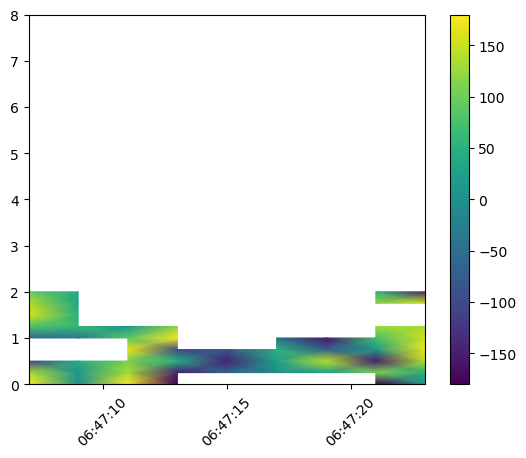

In [42]:
# phase
cpsd_phase_sta = np.degrees(np.angle(cpsd_sta))
cpsd_m_sta = np.abs(cpsd_sta)
cpsd_phase_sta[cpsd_m_sta < 0.03] = np.nan
plt.pcolormesh(ts_dt64_sta, freqs_sta, cpsd_phase_sta, shading='gouraud')
plt.xticks(rotation=45)
plt.colorbar()
plt.show()